In [ ]:
pip install tensorflow
pip install requests
pip install pandas
pip install matplotlib
pip install torch

In [225]:
pip install matplotlib

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [208]:
def merge_json_objects(obj1, obj2):
    merged_data = {}

    #add ojb1 into holding dict. if key is found in both, merge them then add
    for key, value in obj1.items():
        if key in obj2:
            merged_data[key] = value+obj2[key]
        else:
            merged_data[key] = value

    #add obj2 into holding dict only if key not in obj1
    for key, value in obj2.items():
        if key not in merged_data:
            merged_data[key] = value
            
    return merged_data

In [209]:
def get_stock_data(url, next_page_token=None):
    # Make a request to the stock price endpoint
    apiKey = 'PKVVMO4VIR8019Z87DV6'
    apiSecret = 'XlEHA9LpAe3lCmbASJY1Ffze3aRhmCdkhvM1SBnf'
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": apiKey,
        "APCA-API-SECRET-KEY": apiSecret
    }
    response = requests.get(url+next_page_token, headers=headers)
    
    # Check if the response is successful
    if response.status_code == 200:
        # Parse the JSON response
        json_data = response.json()
        bars = json_data['bars']
        # Extract stock data from the current page
        current_page_data = {key: bars[key] for key in bars.keys()}
        # Check if there is a next page
        next_page_token = json_data.get('next_page_token')
        if next_page_token is not None:
            # Recursively fetch and merge the next page data
            next_page_data = get_stock_data(url, '&page_token='+next_page_token)
            current_page_data = merge_json_objects(current_page_data, next_page_data)

        return current_page_data

    else:
        # Handle the case where the API request was not successful
        print(f"Error: {response.status_code}")
        return None


In [210]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import json
import numpy as np

#gets stock data and cleans it
def stock_data(symbols, pathParam, queryParams):
    #base url to build off of
    base_url = "https://data.alpaca.markets/v2/stocks/"

    #add specific api path
    base_url += pathParam

    #add stock symbols to url
    base_url += 'symbols='
    for symbol in symbols:
        base_url += symbol + "%2C";
        base_url[:-3]

    #add params to urls
    for key, value in queryParams.items():
        base_url += "&";
        base_url += key;
        base_url += "=";
        base_url += value;

    #get merged price data
    results = get_stock_data(base_url, '')

    #create list of symbols. FIXME: this could probably use the symbols param. dont know which is faster
    symbols = list(results.keys())
    #create empty dict to hold each symbols data
    tables = {}
    for symbol in symbols:
        #get specific symbol's data
        data = results[symbol]
        
        # Convert timestamp strings to datetime objects
        for point in data:
            #FIXME: make sure every endpoint includes 't' measure
            point["t"] = datetime.strptime(point["t"], "%Y-%m-%dT%H:%M:%SZ")
        
        # Create a Pandas DataFrame
        df = pd.DataFrame(data)
            
            
        # FIXME: This is not needed in prod. Wasted computation. Not agnostic
        df.rename(columns={'c': 'close', 'h':'high', 'l':'low', 'n':'trade_count', 'o':'open', 't':'timestamp', 'v':'bar_volume', 'vw':'price_volume_weighted'}, inplace=True)
    
        # add df to dictionary of dfs
        tables[symbol] = df

    return tables


In [211]:
def create_MACD(data, config):
    firstPerdiod = config['firstPeriod']
    secondPeriod = config['secondPeriod']
    indicator_final = {}

    for symbol, prices in data.items():
        macd1=pd.Series(prices['price_volume_weighted'].ewm(span=firstPerdiod, min_periods=1, adjust=False).mean())
        macd2=pd.Series(prices['price_volume_weighted'].ewm(span=secondPeriod, min_periods=1, adjust=False).mean())
        macd = pd.Series(macd1 - macd2, name='value')
        full_df = pd.concat([data[symbol], macd], axis=1)
        indicator_final[symbol] = full_df
    return {
                'config' : config,
                'values' : indicator_final
            }

def create_RSI(data, config):
    period = config['period']
    indicator_final = {}

    for symbol, prices in data.items():
        price_change=pd.Series(prices['price_volume_weighted'].diff())

        # Calculate the average gain and average loss over a 14-day period
        gain=pd.Series(price_change.apply(lambda x: x if x > 0 else 0))
        loss=pd.Series(price_change.apply(lambda x: abs(x) if x < 0 else 0))
        
        avg_gain=pd.Series(gain.rolling(window=period, min_periods=1).mean())
        avg_loss=pd.Series(loss.rolling(window=period, min_periods=1).mean())
        
        # Calculate the relative strength (RS)
        rs = avg_gain / avg_loss

        # Calculate the RSI
        rsi = pd.Series(100 - (100 / (1 + rs)), name='value')
        full_df = pd.concat([data[symbol], rsi], axis=1)
        indicator_final[symbol] = full_df
    return {
                'config' : config,
                'values' : indicator_final
            }

def create_MA(data, config):
    period = config['period']
    indicator_final = {}
    
    for symbol, prices in data.items():
        ma=pd.Series(prices['price_volume_weighted'].rolling(window=period).mean(), name='value')
        full_df=pd.concat([data[symbol], ma], axis=1)
        indicator_final[symbol]=full_df
    return {
                'config' : config,
                'values' : indicator_final
            }

def create_PriceDelta(data, config):
    period = config['period']
    indicator_final = {}
    
    for symbol, prices in data.items():
        delta=pd.Series(prices['price_volume_weighted'] - prices['price_volume_weighted'].shift(period), name='value')
        full_df=pd.concat([data[symbol], delta], axis=1)
        indicator_final[symbol]=full_df
    return {
                'config' : config,
                'values' : indicator_final
            }

def create_PriceDeltaPercent(data, config):
    period = config['period']
    point = config['point']
    indicator_final = {}
    
    for symbol, prices in data.items():
        delta=pd.Series(abs(prices['price_volume_weighted']-prices['price_volume_weighted'].shift(period)))
        final = pd.Series((delta/prices['price_volume_weighted'].shift(period))*100, name='value') if point == 'initial' else pd.Series((delta/prices['price_volume_weighted'])*100, name='value')
        full_df=pd.concat([data[symbol], final], axis=1)
        indicator_final[symbol]=full_df
    return {
                'config' : config,
                'values' : indicator_final
            }

indicator_functions = {
    'MACD': create_MACD,
    'RSI': create_RSI,
    'MA': create_MA,
    'PriceDelta': create_PriceDelta,
    'PriceDeltaPercent': create_PriceDeltaPercent
}

In [212]:
def create_indicators(stocks, indicator_config):
    indicators_final = {}
    for indicator, config in indicator_config.items():
        # Use the indicator_functions dictionary to get the appropriate function
        indicator_function = indicator_functions.get(indicator)
        if indicator_function:
            # Call the selected function with the corresponding configuration
            indicator_result = indicator_function(stocks, config)
            # append indicator result to dict
            indicators_final[indicator]=indicator_result
        else:
            print(f"Warning: Unknown indicator '{indicator}'. Skipping.")
    return indicators_final

In [213]:
def create_signals(stocks):
    signals_final = {}
    for symbol, bars in stocks.items():
        future_change_abs = pd.Series(bars['price_volume_weighted'].shift(-1) - bars['price_volume_weighted'], name='future_change')
        signal = pd.Series(future_change_abs/bars['price_volume_weighted'], name = 'value')
        full_df=pd.concat([bars[['timestamp']], signal], axis=1)
        signals_final[symbol]=full_df
    return signals_final

In [214]:
def main(symbols, queryParams, pathParam, indicator_config):
    stock_bars = stock_data(symbols, pathParam, queryParams)
    indicators = create_indicators(stock_bars, indicator_config)
    signals = create_signals(stock_bars)
    return indicators, signals

In [215]:
#init config and get stock price data
symbols = ['AAPL', 'TSLA']
queryParams = {
    'timeframe':'3Min',
    'adjustment': 'all',
    'feed': 'iex',
    'sort': 'asc',
    'start': '2020-10-10T00%3A00%3A00Z',
    'limit': '10000'
             }
pathParam = 'bars?'
cut = 7999
#init config and create indicators for each stock
#FIXME: periods here are in # of readings, not days (eg. timeframe=30Min, so period=50 means 3.1 days assuming 8 hour trading day)
indicator_config = {
    'MACD': {
        'firstPeriod': 1920,
        'secondPeriod': 4160,
    },
    'RSI': {
        'period': 2240
    },
    'MA': {
        'period': 8000
    },
    'PriceDelta': {
        'period': 1
    },
    'PriceDeltaPercent': {
        'period': 1,
        'point': 'initial'
    }
}

indicators, signals = main(symbols, queryParams, pathParam, indicator_config)

In [216]:
# Clean and format data
features = {}
outputs = {}
cutin = 7999
cutoff = 1
for symbol in symbols:
    feature = []
    output = []
    for indicator, value in indicators.items():
        feature.append(value['values'][symbol]['value'].iloc[cutin:-cutoff].reset_index(drop=True))
    features[symbol]=feature
    symbol_signal = signals[symbol]['value'].iloc[cutin:-cutoff].reset_index(drop=True)
    #outputs[symbol]=  (2 * (symbol_signal - np.min(symbol_signal)) / (np.max(symbol_signal) - np.min(symbol_signal))) - 1
    outputs[symbol] = symbol_signal
    
        

In [217]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

In [283]:
# Build net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.softmax(x)
        return x
models = {}
for symbol in symbols:
    print(f'creating model for {symbol}')
    train_size = int(0.8 * len(features[symbol][0]))
    feature = features[symbol]
    feature_scaled = [min_max_scaling(feat) for feat in feature]
    output = np.array(outputs[symbol])
    feature_train = np.column_stack(feature_scaled)[:train_size]
    output_train = output[:train_size]
    feature_test = np.column_stack(feature_scaled)[train_size:]
    output_test = output[train_size:]

    X_train_tensor = torch.FloatTensor(feature_train)
    y_train_tensor = torch.FloatTensor(output_train)

    X_test_tensor = torch.FloatTensor(feature_test)
    y_test_tensor = torch.FloatTensor(output_test)


    # Set hyperparameters
    input_size = len(features[symbol])
    hidden_size = 64
    output_size = 1
    learning_rate = 0.001
    epochs = 100

    # Create an instance of the model
    model = NeuralNetwork(input_size, hidden_size, output_size)
    
    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Prepare DataLoader for training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    # Training loop
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()
    
            # Forward pass
            model_output = model(inputs)
            
            # Compute the loss
            labels = labels.view_as(model_output)
            loss = criterion(model_output, labels)

            # Backward pass
            loss.backward()
    
            # Update weights
            optimizer.step()
    
        # Print the training loss for each epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    models[symbol] = model

creating model for AAPL
Epoch 1/100, Loss: 2.476398776707356e-06
Epoch 2/100, Loss: 4.273125341569539e-06
Epoch 3/100, Loss: 2.170660809497349e-05
Epoch 4/100, Loss: 2.1429985281429254e-05
Epoch 5/100, Loss: 2.5808427380979992e-05
Epoch 6/100, Loss: 3.094881321885623e-05
Epoch 7/100, Loss: 2.117615076713264e-05
Epoch 8/100, Loss: 1.4941688277758658e-05
Epoch 9/100, Loss: 1.3895457414037082e-05
Epoch 10/100, Loss: 9.556380973663181e-06
Epoch 11/100, Loss: 4.085563432454364e-06
Epoch 12/100, Loss: 2.9350553631957155e-06
Epoch 13/100, Loss: 1.7191614460898563e-06
Epoch 14/100, Loss: 4.02426394430222e-06
Epoch 15/100, Loss: 2.1092657789267832e-06
Epoch 16/100, Loss: 2.1893595203437144e-06
Epoch 17/100, Loss: 2.6231937226839364e-06
Epoch 18/100, Loss: 3.1489141747442773e-06
Epoch 19/100, Loss: 2.919030748671503e-06
Epoch 20/100, Loss: 2.2587303192267427e-06
Epoch 21/100, Loss: 2.1274520349834347e-06
Epoch 22/100, Loss: 1.95472830455401e-06
Epoch 23/100, Loss: 1.923445324791828e-06
Epoch 24/

In [276]:
model = models['TSLA']

with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    # mse_loss = criterion(test_outputs, y_test_tensor)    
    result = (test_outputs >= 0) == (y_test_tensor >= 0)
    correct_direction = torch.sum(result).item() / (len(y_test_tensor)*100)
    print(correct_direction)

94.4112199907068


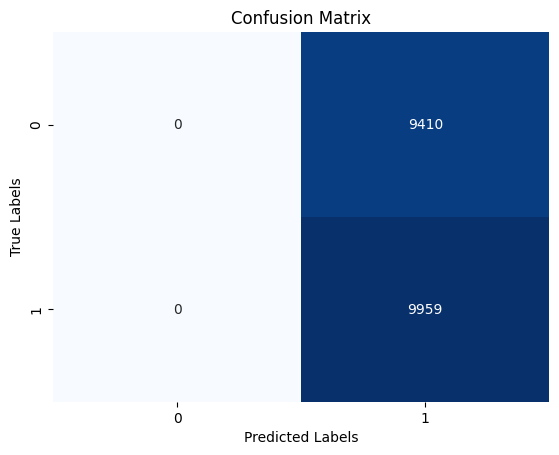

In [282]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model = models['TSLA']

with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    threshold = 0.0

    # Convert probabilities to binary predictions
    predicted_labels = [1 if num > 0 else -1 for num in test_outputs]
    # Convert tensors to numpy arrays
    y_true = y_test_tensor.numpy().flatten()
    #y_pred = predicted_labels.numpy().flatten()
    true_labels = [1 if num > 0 else -1 for num in y_true]

    #print((y_test_tensor))
    
    # Create the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix using seaborn
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [202]:
print(train_loader)

In [198]:
print(feature_train)

[[0.00124482 0.00227307 0.2430122  0.52024198 0.03880373]
 [0.001172   0.00687358 0.24286454 0.53494763 0.10285324]
 [0.00108282 0.         0.24271842 0.47318439 0.16533976]
 ...
 [0.49935922 0.3846403  0.96482566 0.49908232 0.02085426]
 [0.49948862 0.38372151 0.96480742 0.50501074 0.0108137 ]
 [0.49961342 0.38208124 0.96478858 0.5013532  0.01704263]]


In [ ]:
print(features['AAPL'][0])

In [193]:
min_max_scaling(features['TSLA'][0])

-21.24877906349971
22.584237359335532


0        0.001245
1        0.001172
2        0.001083
3        0.000992
4        0.000915
           ...   
31280    0.559791
31281    0.559908
31282    0.560029
31283    0.560158
31284    0.560291
Name: value, Length: 31285, dtype: float64

In [ ]:
features['AAPL'][0].plot(y='value', kind='line', linestyle='-', color='b', figsize=(20, 6))
plt.title(f'Time vs RSI')
plt.xlabel('Time')
plt.ylabel('rsi')
plt.grid(True)
# print(indicators['PriceDelta']['values']['AAPL'])